In [1]:
from openslide import OpenSlide
import os
import numpy as np
from matplotlib import pyplot
import cv2          

import re
import multiprocessing
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import sklearn
import sklearn.manifold
import seaborn as sns

Code below is modified from: https://medium.com/geekculture/image-thresholding-from-scratch-a66ae0fb6f09

In [2]:
def _compute_otsu_criteria(im, th):
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]/255
    val_pixels0 = im[thresholded_im == 0]/255

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return (weight0 * np.sqrt(var0) + weight1 * np.sqrt(var1))*1/weight0*1/weight1

def otsuThresholding(img_in: np.ndarray) -> np.ndarray:
    threshold_range = range(np.max(img_in)+1)
    criterias = np.array([_compute_otsu_criteria(img_in, th) for th in threshold_range])

    # best threshold is the one minimizing the Otsu criteria
    best_threshold = threshold_range[np.argmin(criterias)]

    binary = img_in.copy()
    binary[binary > best_threshold] = 255
    binary[binary <= best_threshold] = 0

    return best_threshold, binary


In [3]:
slides_path = '/omics/odcf/analysis/OE0606_projects/pancancer_histopathology/data/UKHD_NP_HE_NEW_BATCH_1'

In [4]:
slides = os.listdir(slides_path)

In [5]:
slides = [slide for slide in slides if ".svs" in slide]

In [6]:
len(slides)

2373

In [14]:
slides[0]

'B69C1475-5B7B-4351-ACC2-5B87FCB31497.svs'

In [15]:
slide = OpenSlide(slides_path+"/"+slides[0])

In [16]:
tb = slide.get_thumbnail((512,512))

In [17]:
tba = np.array(tb)

In [18]:
img = cv2.cvtColor(tba, cv2.COLOR_BGR2GRAY) 

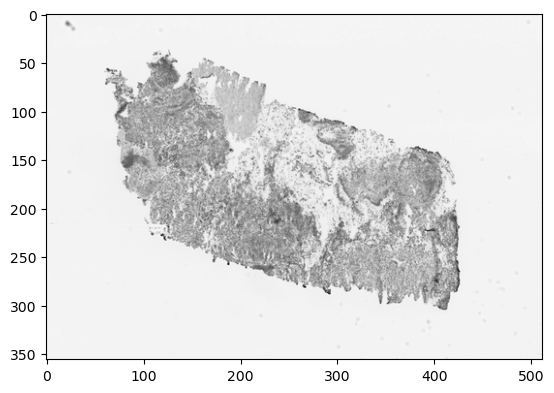

In [19]:
pyplot.imshow(img, cmap='gray')

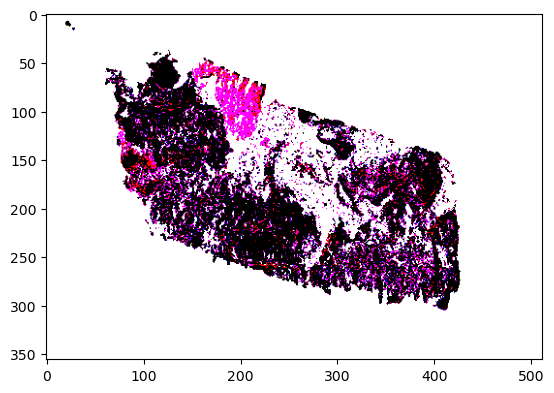

In [20]:
pyplot.imshow((tba > 200).astype(float))

In [21]:
ret, thresh1 = cv2.threshold(img, 1, 255,  cv2.THRESH_OTSU) 

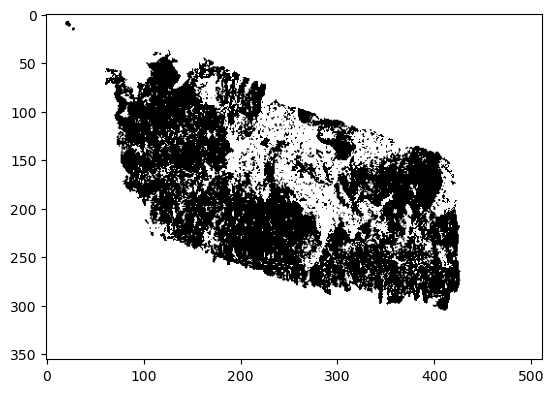

In [22]:
pyplot.imshow(thresh1, cmap="gray")

In [23]:
ret, thresh1 = otsuThresholding(img)

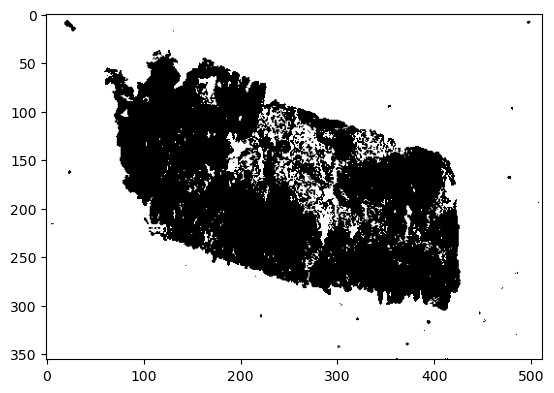

In [24]:
pyplot.imshow(thresh1, cmap="gray")

In [25]:
tba[thresh1==0].mean(0)

array([188.33750515, 167.51607524, 189.75735377])

In [26]:
def getMeanTissueColor(slidename):
    slide = OpenSlide(slides_path+"/"+slidename)
    tb = slide.get_thumbnail((512,512))
    tba = np.array(tb)
    img = cv2.cvtColor(tba, cv2.COLOR_BGR2GRAY) 
    ret, thresh1 = otsuThresholding(img)
    return tba[thresh1==0].mean(0)


In [27]:
%time res = [getMeanTissueColor(sl) for sl in slides[0:10]]

CPU times: user 11.5 s, sys: 922 ms, total: 12.4 s
Wall time: 17.1 s


In [ ]:
res = [getMeanTissueColor(sl) for sl in slides]

In [37]:
mean_array = np.stack(res)

Next step: do PCA, see what happens. 

In [38]:
pca = decomposition.PCA(n_components=2)

In [39]:
pca_fit = pca.fit_transform(StandardScaler().fit_transform(mean_array))

In [40]:
pca_fit

array([[ 0.0453154 ,  0.4546968 ],
       [-0.25535088, -0.09912518],
       [-1.78628585,  0.11970807],
       ...,
       [-0.34495434, -0.1734967 ],
       [ 2.66400438,  0.19589667],
       [-1.55156808,  0.0163257 ]])

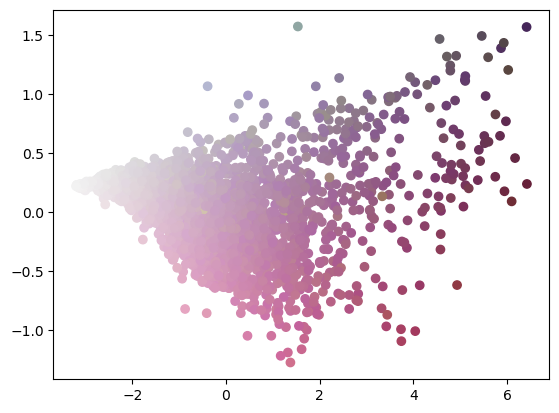

In [41]:
pyplot.scatter(pca_fit[:,0], pca_fit[:,1], color=mean_array/255)

In [42]:
outliers = np.argwhere(np.logical_and(pca_fit[:,0] > 5, pca_fit[:,1]>1))

In [43]:
len(outliers)

9

In [46]:
slides[outliers]

TypeError: only integer scalar arrays can be converted to a scalar index

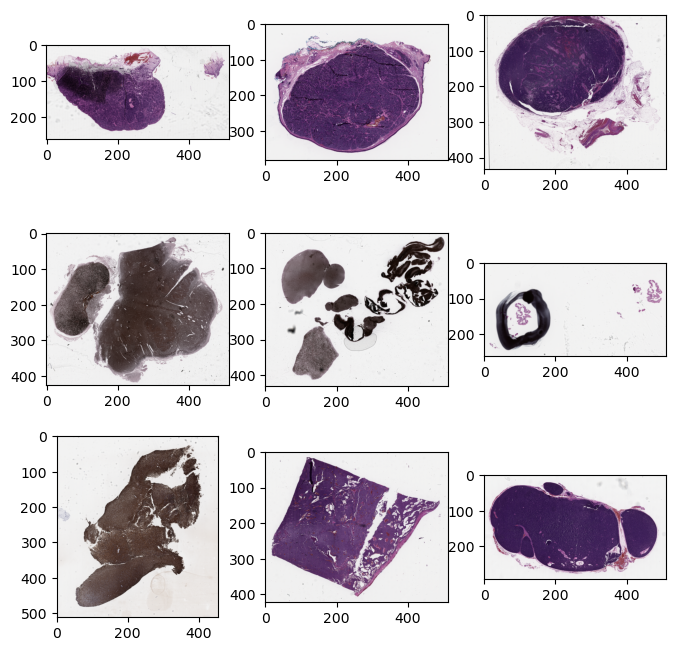

In [44]:
fig = pyplot.figure(figsize=(8, 8))
columns = 3
rows = 3
j = 1
for i in outliers:
    slide = OpenSlide(slides_path+"/"+slides[i.item()])
    tb = slide.get_thumbnail((512,512))
    fig.add_subplot(rows, columns, j)
    pyplot.imshow(np.array(tb))
    j = j + 1
pyplot.show()


In [53]:
slides[outliers[0].item()]

'B734119C-9981-4882-A822-A1D23D03B924.svs'

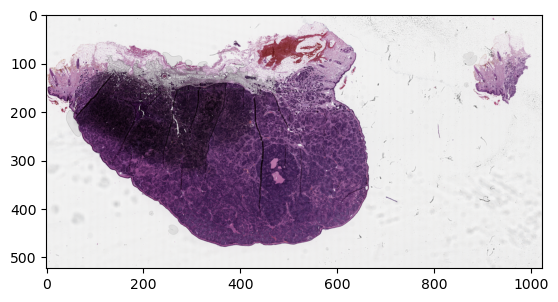

In [54]:
slide =  OpenSlide(slides_path+"/"+slides[outliers[0].item()])
tb = slide.get_thumbnail((1024,1024))
pyplot.imshow(np.array(tb))

In [42]:
random_slides = np.random.randint(0, len(slides), 36)

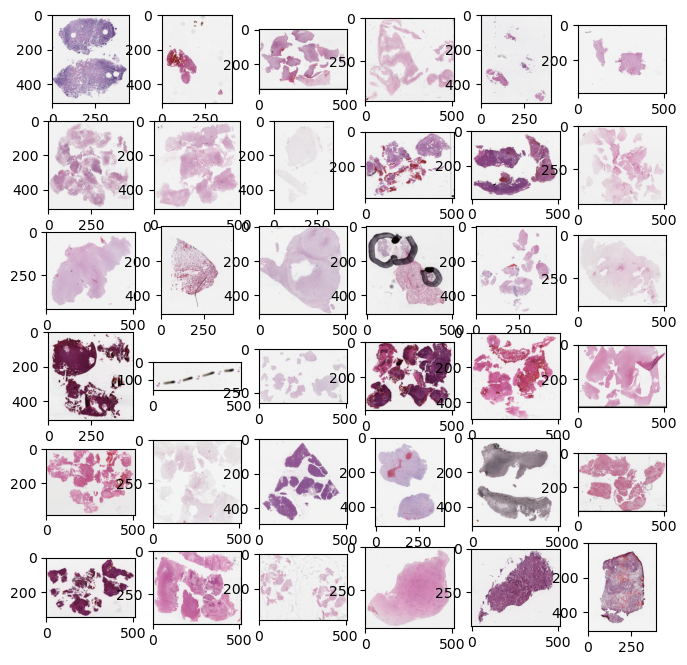

In [43]:
fig = pyplot.figure(figsize=(8, 8))
columns = 6
rows = 6
j = 1
for i in random_slides:
    slide = OpenSlide(slides_path+"/"+slides[i.item()])
    tb = slide.get_thumbnail((512,512))
    fig.add_subplot(rows, columns, j)
    pyplot.imshow(np.array(tb))
    j = j + 1
pyplot.show()


Looks like the PCA is pretty good at capturing slides that are mostly scribbled on, or those that clearly are not H&E (see example above). I am not sure whether there is a perfect cutoff, but its probably best to exclude the extreme cases from the analysis. 

In [44]:
distance_from_origin_pca = np.flip(np.linalg.norm(pca_fit,axis=1).argsort())[0:36]

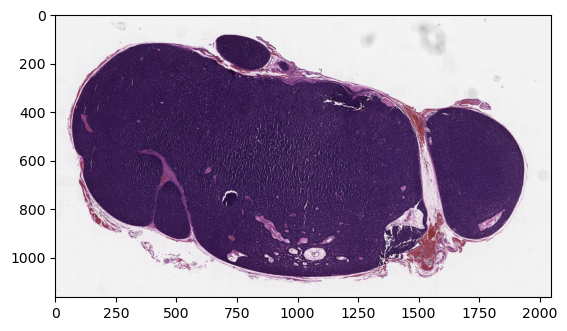

In [46]:
slide = slides[distance_from_origin_pca[0]]
slide =  OpenSlide(slides_path+"/"+slide)
tb = slide.get_thumbnail((2048,2048))
pyplot.imshow(np.array(tb))

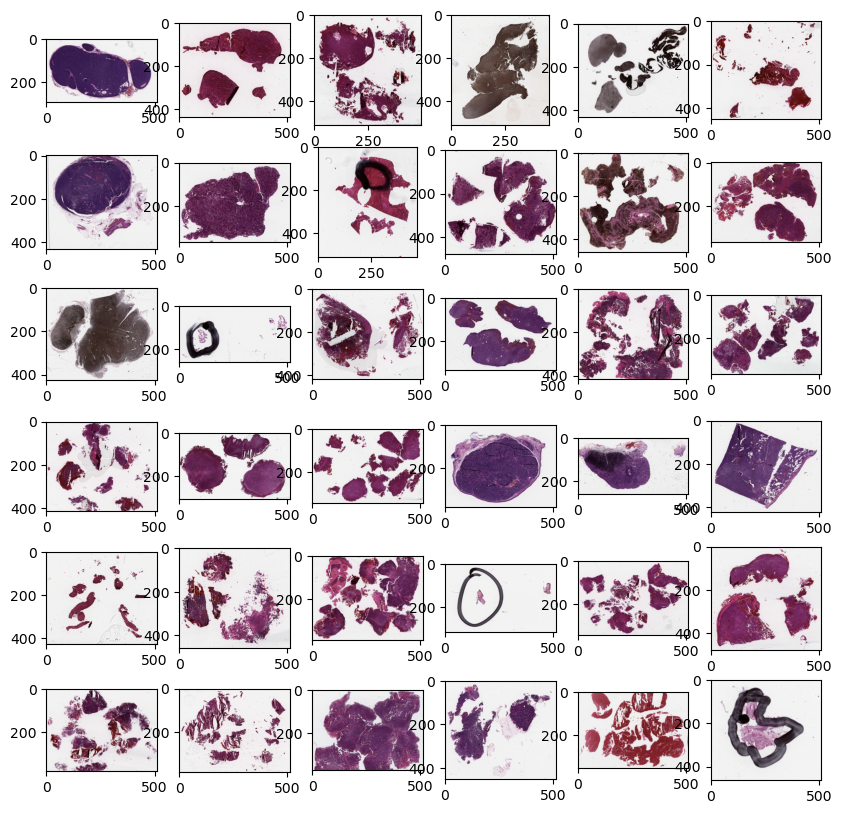

In [50]:
fig = pyplot.figure(figsize=(10,10))
rows = 6
columns = 6
j = 1
for i in distance_from_origin_pca:
    slide = OpenSlide(slides_path+"/"+slides[i])
    tb = slide.get_thumbnail((512,512))
    fig.add_subplot(rows, columns, j)
    pyplot.imshow(np.array(tb))
    j = j + 1
pyplot.show()

In [55]:
tsne = sklearn.manifold.TSNE().fit_transform(mean_array)

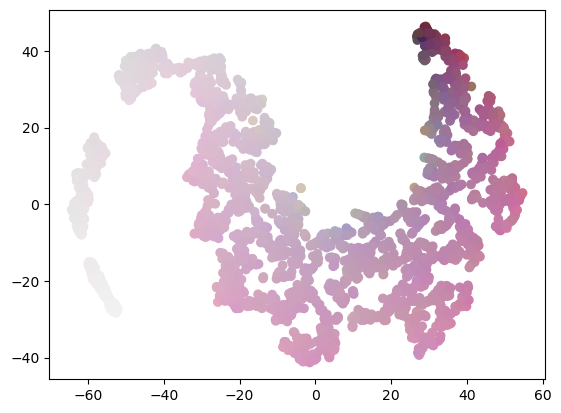

In [56]:
pyplot.scatter(tsne[:,0], tsne[:,1], color=mean_array/255)

In [81]:
myx = np.argwhere((mean_array < [100,100,100]).sum(1)==3).reshape(-1)

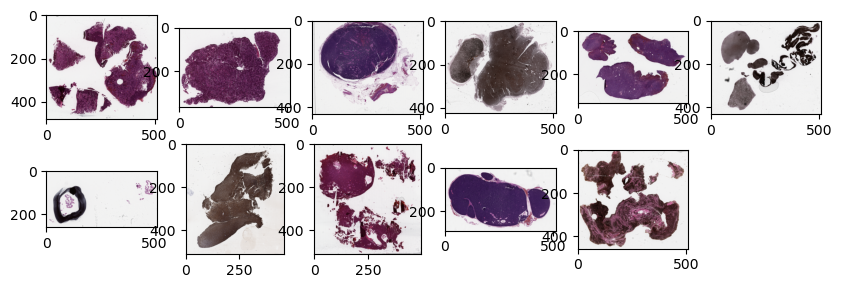

In [83]:
fig = pyplot.figure(figsize=(10,10))
rows = 6
columns = 6
j = 1
for i in myx:
    slide = OpenSlide(slides_path+"/"+slides[i.item()])
    tb = slide.get_thumbnail((512,512))
    fig.add_subplot(rows, columns, j)
    pyplot.imshow(np.array(tb))
    j = j + 1
pyplot.show()

In [82]:
len(myx)


11